In [1]:
import torch

In [2]:
# plotting training loss of some checkpoints
path = "D:\\weights\\test\\urban\\checkpoint29"
checkpoint = torch.load(path)


C:\Users\eros\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TL = checkpoint['training_loss_values']
VL = checkpoint['validation_loss_values']

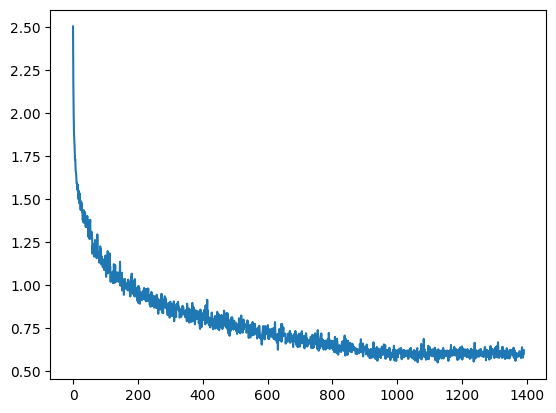

In [4]:
import matplotlib.pyplot as plt
import numpy as np
group = 100
means = [np.mean(TL[i:i+group]) for i in range(0, len(TL), group)]
plt.plot(means)

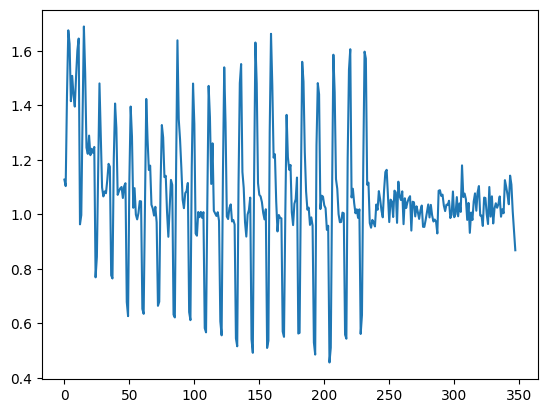

In [6]:
group = 100
means = [np.mean(VL[i:i+group]) for i in range(0, len(VL), group)]
plt.plot(means)

In [89]:
print(checkpoint['batch_size'])

32
